### Grocery Store Access for Seniors in the City of Los Angeles
<b>Team:</b> Carolyn Pugh, Lucy Briggs, Monisha Reginald<br><br>
<b>Research Question</b>: Where do gaps in access to grocery stores by non-automobile modes exist for seniors who live in the city of Los Angeles?<br>
<b>Notbook Purpose:</b> This notebook explores the locations of seniors, senior-headed households without access to a vehicle, grocery stores, and transit stops within the City of Los Angeles to inform the group's understanding of which neighborhoods warrant further exploration.<br><br>
<b>Data Sources</b>
1. Los Angeles County Census Block Group Boundaries [downloaded from LA GeoHub](https://geohub.lacity.org/datasets/lacounty::census-block-groups-2020/explore?location=33.869009%2C-118.309786%2C9.25)
2. Los Angeles City Boundary [imported directly via API from LA GeoHub](https://geohub.lacity.org/maps/city-boundary)
3. Los Angeles Times Neighborhood Boundaries [imported directly via API From LA GeoHub](https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0/explore?location=34.020320%2C-118.410084%2C10.96)
4. ACS 2021 5-Year Estimates [imported directly via API from United States Census Bureau](https://www.census.gov/data/developers/data-sets/acs-5year.html)
5. SNAP Store Locations [imported directly via API from USDA](https://usda-fns.hub.arcgis.com/datasets/USDA-FNS::snap-store-locations/explore?location=14.817317%2C-14.634785%2C2.79)

In [1]:
# Import basic packages.
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Import packages for plots and maps. 
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.express as px

# Import libraries for doing network analysis with open street map. 
import networkx as nx
import osmnx as ox

#### Part 1: Seniors in Los Angeles

#### Part 2: Senior Vehicle-Access in Los Angeles

First, we read in the geojson created in the Prep Notebook, which contains information about vehicle ownership for all block groups in the City of Los Angeles.

In [2]:
vehicle_access=gpd.read_file('vehicle_access.geojson')

We are interested in vehicle ownership rates for the City of LA, so we will calcualte stats across the block groups.

In [3]:
# Calculate sum across all block groups (results in a series) and then convert that series to a dataframe.
city_totals=vehicle_access.sum(numeric_only=True).to_frame().transpose()

# Recalculate percentages.
city_totals['Pct Households Without a Vehicle']=(city_totals['Total No Vehicle']/city_totals['Total HH'])*100
city_totals['Pct Senior-Headed Households Without a Vehicle']=(city_totals['Senior No Vehicle']/city_totals['Senior HH'])*100

# Inspect results.
city_totals

Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0  1385427.0   287185.0          161724.0            58193.0   

   Pct Households Without a Vehicle  \
0                         11.673224   

   Pct Senior-Headed Households Without a Vehicle  
0                                       20.263245

We can see that seniors are almost twice as likely to lack access to a household vehicle. We will make a bar chart so that this information can be displayed visually in presentations.

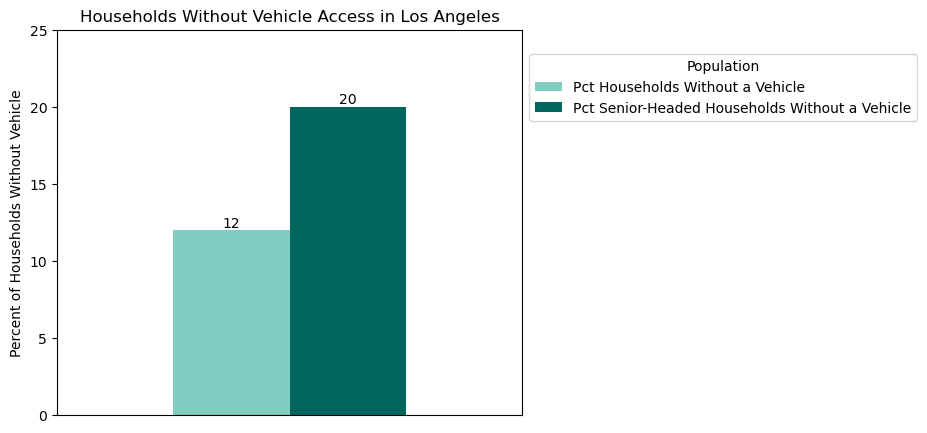

In [4]:
# Create a dataframe for chart with just rounded percentages (so that they can be displayed).
city_bar=city_totals[['Pct Households Without a Vehicle', 'Pct Senior-Headed Households Without a Vehicle']].round()

# Start plot.
fig, ax = plt.subplots(figsize=(6,5))

# Plot data and label the two bars with their values.
ax = city_bar.plot(ax=ax, kind='bar', color=['#80cdc1','#01665e'], legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis so it doesn't have a subtitle or ticks.
plt.xlabel(None)
ax.set_xticks([])

# Ajust y-axis so that it has desired subtitle and ticks.
plt.ylabel("Percent of Households Without Vehicle")
ax.set_yticks((0,5,10,15,20,25))

#Adjust table and legend.
plt.title("Households Without Vehicle Access in Los Angeles")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Population')

plt.show()

We want to understand how vehicle access and senior-vehicle access relate to each other, so we'll create a scatter plot.

Text(0.5, 1.0, 'Household Vehicle Access at Block Group Level')

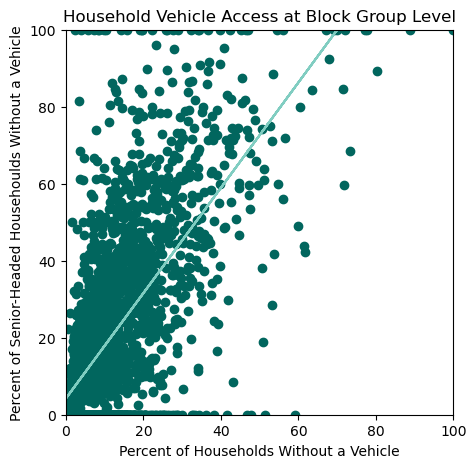

In [5]:
# Create filtered version that exclused all rows with missing data
census_linear=vehicle_access[(vehicle_access["Pct Households Without a Vehicle"]>=0) & (vehicle_access["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Calculate line of best fit for this filtered dataframe.
m, b = np.polyfit(census_linear["Pct Households Without a Vehicle"], census_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

# Start plot
fig,ax = plt.subplots(figsize=(5,5))

# Plot all points and line of best fit.
ax = plt.plot(census_linear["Pct Households Without a Vehicle"], census_linear["Pct Senior-Headed Households Without a Vehicle"], 'o', color='#01665e')
ax = plt.plot(census_linear["Pct Households Without a Vehicle"], m*census_linear["Pct Households Without a Vehicle"] + b, color='#80cdc1')

plt.xlim(0,100)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,100)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Block Group Level")

From this plot, we can see that vehicle ownership and senior vehicle ownership trend together, but that seniors are systematically less likely to own a vehicle than the general population.

Finally, we want to see this information visually mapped to understand geographic trends. We'll create a new version of this dataframe that replaces "N/A" values (which result when there are either no people or no seniors within a block group) with 0s, so that they are visually grouped with other areas where there is less need to invest in transit infrastructure.

In [6]:
# Create a new dataframe for mapping purposes.
vehicle_map=vehicle_access

# Set value of 0 on rows where the percentages are currently "N/A"
vehicle_map['Pct Households Without a Vehicle'] = vehicle_map['Pct Households Without a Vehicle'].fillna(0)
vehicle_map['Pct Senior-Headed Households Without a Vehicle'] = vehicle_map['Pct Senior-Headed Households Without a Vehicle'].fillna(0)

We want to map the block groups pased on their senior vehicle-ownership percentages, so we'll categorize them based on areas with no vehicle-free househoulds, areas where 0-20% of senior-headed households lack a vehicle, and areas where over 20% (the City average) of senior-headed households lack a vehicle. Note that these percentages can be adjusted.

In [7]:
# First we have to sort and re-index this dataframe so the row number corresponds to its rank.
vehicle_map=vehicle_map.sort_values(by=['Pct Senior-Headed Households Without a Vehicle']).reset_index().drop(columns=['index'])

# Categorize rows according to their row percentile
vehicle_map['Senior_Category']= '0% of Senior-Headed Households Lack Vehicle'
vehicle_map.loc[vehicle_map['Pct Senior-Headed Households Without a Vehicle'] > 0, 'Senior_Category'] = "1-20% of Senior-Headed Households Lack Vehicle"
vehicle_map.loc[vehicle_map['Pct Senior-Headed Households Without a Vehicle'] > 20, 'Senior_Category'] = "Over 20% of Senior-Headed Households Lack Vehicle"

Now we can make the map!

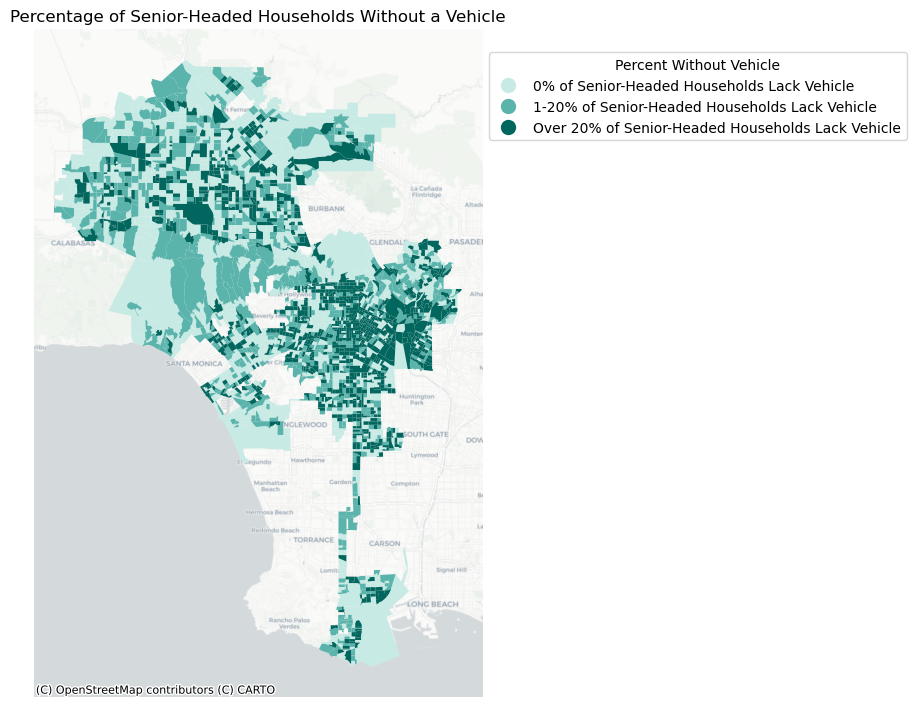

In [8]:
# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'0% of Senior-Headed Households Lack Vehicle' : '#c7eae5',
              '1-20% of Senior-Headed Households Lack Vehicle': '#5ab4ac',
              'Over 20% of Senior-Headed Households Lack Vehicle': '#01665e'}

vehicle_map["colors"] = vehicle_map["Senior_Category"].map(color_dict)

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(8,8))
ax = vehicle_map.plot(ax=ax, color=vehicle_map["colors"])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc="center left", bbox_to_anchor=(1,.9), title="Percent Without Vehicle")


#Format plot.
ax.axis('off')
ax.set_title('Percentage of Senior-Headed Households Without a Vehicle')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.tight_layout()

This map is helful for understanding the detailed geographic trends - the areas with the lowest car ownership seem to be concentrated near Centeral Los Angeles and also scattered throughout the San Fernando Valley. However, to aid our selection of neighborhoods, we also want to understand vehicle access by neighborhood. To do this, we will aggregate data by neighborhood and then recalculate car ownership rates.

In [9]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})

In [10]:
# Create a new dataframe with totals for each neighborhood that sums up all relevant columns.
vehicles_by_neighborhood = vehicle_access.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

# Recalculate percentages.
vehicles_by_neighborhood['Pct Households Without a Vehicle']=(vehicles_by_neighborhood['Total No Vehicle']/vehicles_by_neighborhood['Total HH'])*100
vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle']=(vehicles_by_neighborhood['Senior No Vehicle']/vehicles_by_neighborhood['Senior HH'])*100

# Finally, we have to add back in the geometry column from the original neighborhood geodataframe.
vehicles_by_neighborhood=pd.merge(neighborhoods[['neighborhood','geometry']],vehicles_by_neighborhood,how="left", on=['neighborhood'])

# See how this table looks.
vehicles_by_neighborhood.head()

neighborhood                                           geometry  \
0         Adams-Normandie  POLYGON ((1972233.388 559643.685, 1971938.035 ...   
1                  Arleta  POLYGON ((1959244.309 584850.051, 1959257.540 ...   
2       Arlington Heights  POLYGON ((1970582.552 561395.372, 1970757.410 ...   
3         Atwater Village  MULTIPOLYGON (((1974284.934 572493.221, 197428...   
4  Baldwin Hills/Crenshaw  POLYGON ((1966656.952 558331.179, 1966727.113 ...   

   Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0      5141        915               960                294   
1      7950       1791               337                164   
2      6220       1151               940                256   
3      4782       1207               279                126   
4     14391       3609              2323                835   

   Pct Households Without a Vehicle  \
0                         18.673410   
1                          4.238994   
2                         15.112540   
3                          5.834379   
4                         16.142033   

   Pct Senior-Headed Households Without a Vehicle  
0                                       32.131148  
1                                        9.156896  
2                                       22.241529  
3                                       10.439105  
4                                       23.136603

First, I will create a scatter plot to get a general picture of vehicle access and senior vehicle access at the neighborhoood level.

Text(0.5, 1.0, 'Household Vehicle Access at Neighborhood Level')

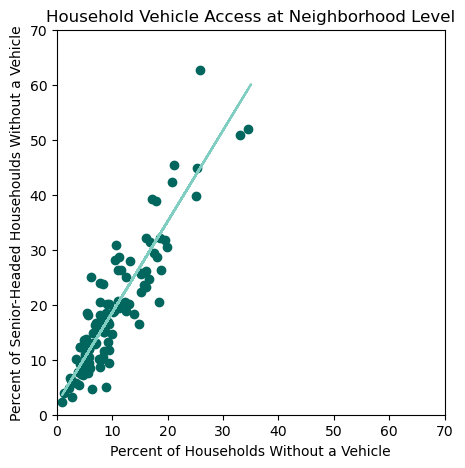

In [11]:
neighborhood_linear=vehicles_by_neighborhood[(vehicles_by_neighborhood["Pct Households Without a Vehicle"]>=0) &
                                      (vehicles_by_neighborhood["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Create line of best fit.
m, b = np.polyfit(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

fig,ax = plt.subplots(figsize=(5,5))

# Plot scatter plot and line of best fit.
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"],
              'o', color='#01665e')
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], m*neighborhood_linear["Pct Households Without a Vehicle"] + b,
             color='#80cdc1')

plt.xlim(0,70)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,70)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Neighborhood Level")

This scatter plot shows that vehicle access and senior vehicle access trend closely, but that seniors are much less likely to own a vehicle. This scatter plot also helps us understand that there are 10 neighborhoods that have particularly high rates of zero-vehicle households (the 10 points far away from the cluster of other points). To understand where these outliers are, we created a bar chart of the top 10 neighborhoods where senior-headed households are the least likely to own a vehicle.

Text(0.5, 1.0, 'Top 10 Neighborhoods by Pct of Senior-Headed Households That Do Not Have Vehicle')

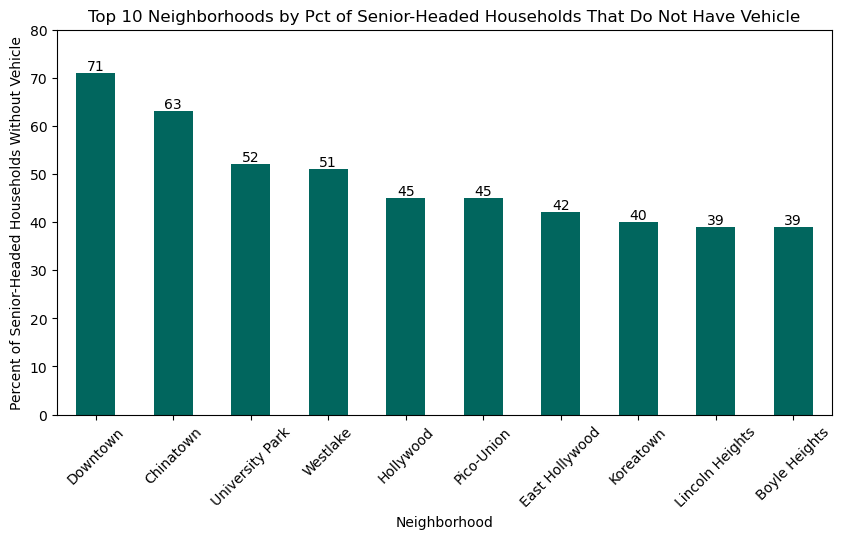

In [12]:
# Create a dataframe for chart with sorted, rounded percentages (so that they can be displayed).
neighborhood_bar=vehicles_by_neighborhood[['neighborhood','Pct Senior-Headed Households Without a Vehicle']].round().sort_values(by=['Pct Senior-Headed Households Without a Vehicle'],ascending=False)

# Start plot.
fig, ax = plt.subplots(figsize=(10,5))
ax = neighborhood_bar[:10].plot(ax=ax, kind='bar', x='neighborhood', y= 'Pct Senior-Headed Households Without a Vehicle', color=['#01665e'], legend=False)
ax.bar_label(ax.containers[0], label_type='edge')

# Adjust x-axis.
plt.xlabel("Neighborhood")
plt.xticks(rotation=45)

# Ajust y-axis.
plt.ylabel("Percent of Senior-Headed Households Without Vehicle")
ax.set_yticks((0,10,20,30,40,50,60,70,80))

#Adjust table and legend.
plt.title("Top 10 Neighborhoods by Pct of Senior-Headed Households That Do Not Have Vehicle")

From this chart, we learn that the neighborhoods where seniors are concentrated in Central and East Los Angeles.

#### Part 3: Grocery Store Access in Los Angeles

Next, we turn to the question of where chain grocery stores are located within the City of Los Angeles. Although we would prefer to include non-chain grocery stores as well, there's no reasonable way to identify them for the entire City of Los Angeles. We will likely be able to manually include these if we zoom in on a small number of neighborhoods in future analysis. <br>First, we read in the geojson created in the Prep Notebook, which contains information about the grocery stores. For initial analysis, we want to analyze just grocery chains within the municipal border.

In [13]:
# Read file.
grocery_chains=gpd.read_file('chain_with_neighborhood.geojson')

# Create new geodataframe with just chains within the City of LA.
chain_with_neighborhood=grocery_chains[grocery_chains['neighborhood'].notna()].copy().reset_index().drop(columns=['index'])

We want to make a map of grocery stores in Los Angeles categorized by their chain. However, there are too many supermarket chains to map them with every chain as its own category, so I will create a new dataframe for the primary purpose of mapping. This new dataframe will contain a column (chain_map) that contains the chain's name for very big chains, and the chain type for smaller chains. First, I determine what the top 5 chains are.

In [14]:
# Display fist five items in a new dataframe with counts of each chain.
top_chains = chain_with_neighborhood.value_counts(['chain_name']).reset_index(name='count').iloc[:5]
top_chains

chain_name  count
0         Ralphs     43
1         Target     30
2  Smart & Final     30
3   Trader Joe's     22
4    Food 4 Less     21

Now I can use this information to create my new chain_map categories.

In [15]:
#Create new geodataframe for map.
chain_map=chain_with_neighborhood.copy()

# Create new variable that defaults to the chain type.
chain_map['chain_map'] = chain_map['chain_type']

# Replace value with the chain's name for Top 5 Chains.
chain_map.loc[chain_map['chain_name'] == "Ralphs", 'chain_map'] = "Ralphs"
chain_map.loc[chain_map['chain_name'] == "Smart & Final", 'chain_map'] = "Smart & Final"
chain_map.loc[chain_map['chain_name'] == "Target", 'chain_map'] = "Target"
chain_map.loc[chain_map['chain_name'] == "Trader Joe's", 'chain_map'] = "Trader Joe's"
chain_map.loc[chain_map['chain_name'] == "Food 4 Less", 'chain_map'] = "Food 4 Less"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0  Standard chain (e.g. Ralphs, Trader Joe's)    102
1                                      Ralphs     43
2         Upscale (e.g. Whole Foods, Sprouts)     38
3                               Smart & Final     30
4                                      Target     30
5  Discount (e.g. Smart & Final, Food 4 Less)     25
6                                Trader Joe's     22
7                                 Food 4 Less     21
8     Department store (e.g. Target, Walmart)      5

I notice that by pulling the Targets out separately, there aren't enough department stores to map as a category, so I'll fold these into standard chains.

In [16]:
chain_map.loc[chain_map['chain_name'] == "Walmart", 'chain_map'] = "Standard chain (e.g. Ralphs, Trader Joe's)"

Finally, I must rename my categories to remove references to chains that have been pulled out.

In [17]:
chain_map.loc[chain_map['chain_map'] == "Standard chain (e.g. Ralphs, Trader Joe's)", 'chain_map'] = "Other Standard Chain (e.g. Vons)"
chain_map.loc[chain_map['chain_map'] == "Discount (e.g. Smart & Final, Food 4 Less)", 'chain_map'] = "Other Discount Chain (e.g. Mother's Nutritional Center)"
chain_map.loc[chain_map['chain_map'] == "Upscale (e.g. Whole Foods, Sprouts)", 'chain_map'] = "Upscale Chain (e.g. Whole Foods)"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0                   Other Standard Chain (e.g. Vons)    107
1                                             Ralphs     43
2                   Upscale Chain (e.g. Whole Foods)     38
3                                      Smart & Final     30
4                                             Target     30
5  Other Discount Chain (e.g. Mother's Nutritiona...     25
6                                       Trader Joe's     22
7                                        Food 4 Less     21

Now I can create an interactive map that has the locations of each supermarket chain grocery store in the City of LA. This map helps us understand the spatial distribution of chains overall and _which_ chains are in which areas.

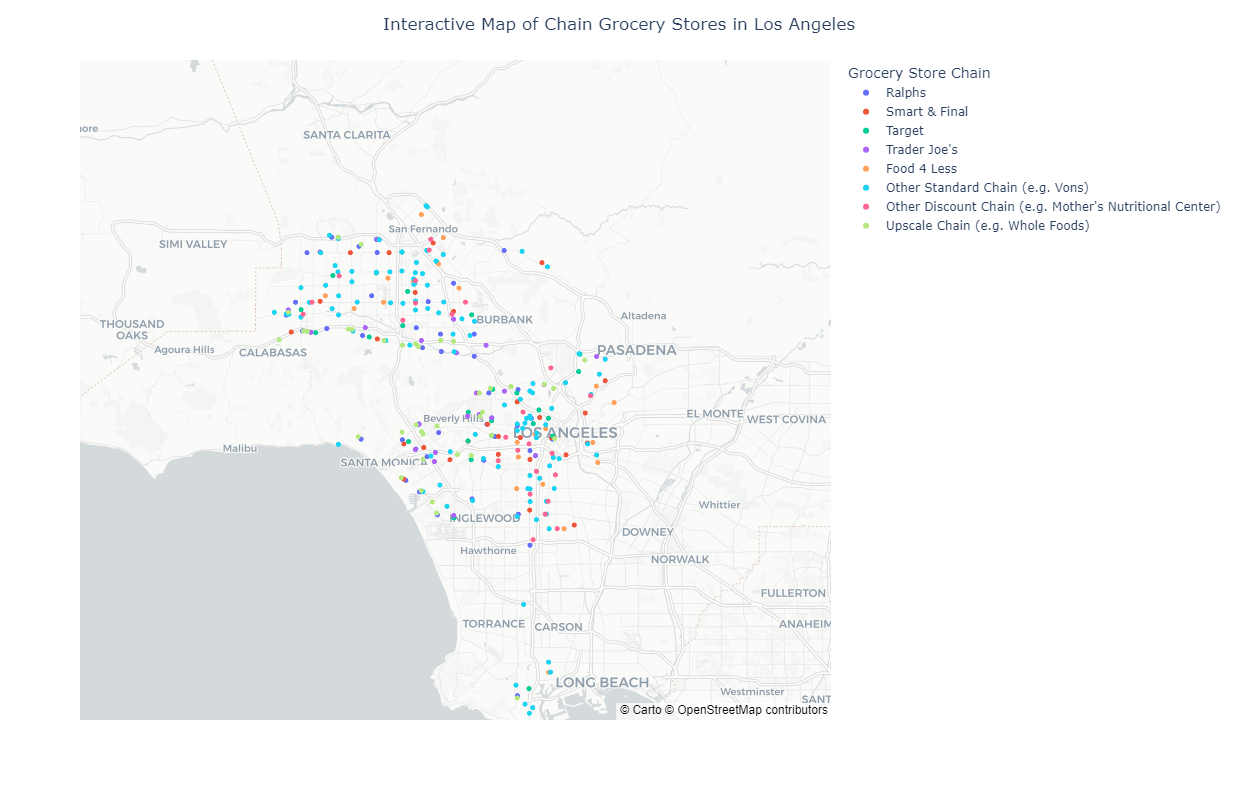

In [18]:
# Create an order column with the desired order (in the legend I want first the top 5 chains in descending order of prevalence and then the chain groups)
chain_map.loc[chain_map['chain_map'] == "Ralphs", 'chain_map_order'] = 1
chain_map.loc[chain_map['chain_map'] == "Smart & Final", 'chain_map_order'] = 2
chain_map.loc[chain_map['chain_map'] == "Target", 'chain_map_order'] = 3
chain_map.loc[chain_map['chain_map'] == "Trader Joe's", 'chain_map_order'] = 4
chain_map.loc[chain_map['chain_map'] == "Food 4 Less", 'chain_map_order'] = 5
chain_map.loc[chain_map['chain_map'] == "Other Standard Chain (e.g. Vons)", 'chain_map_order'] = 6
chain_map.loc[chain_map['chain_map'] == "Other Discount Chain (e.g. Mother's Nutritional Center)", 'chain_map_order'] = 7
chain_map.loc[chain_map['chain_map'] == "Upscale Chain (e.g. Whole Foods)", 'chain_map_order'] = 8

# Sort by my new order column.
chain_map=chain_map.sort_values('chain_map_order')

# Create an interactive map where markers are colored by the name of the chain.
fig = px.scatter_mapbox(chain_map,
                        lat='Latitude',
                        lon='Longitude',
                        color='chain_map',
                        mapbox_style="carto-positron",
                        labels={
                            'chain_map':'Grocery Store Chain',
                        })

# Update layout with desired size, zoom, title, etc.
# Chart specifically must be wider to accomodate the longer names in the legend.
fig.update_layout(
    width = 950,
    height = 800,
    mapbox_style="carto-positron",
    mapbox_zoom=9,
    title = "Interactive Map of Chain Grocery Stores in Los Angeles",
    title_x=0.5)

fig.show()

Exploring this map helps us understand geographic trends - for example, Ralphs has virtually no presence east of Downtown despite being the largest chain in the region. Additionally, you can see very start indications of segregation. While "Discount Chains" are concentrated in South LA, "Upscale Chains" are generally concentrated in West LA and along the 101. These trends are interesting for thinking about grocery store access in terms of affordability in addition to physical accessibility.

Now we turn our attention to the question of which areas are within walking distance of a grocery store. First, we'll read in the geojsons that we'll need, with the most notable one being the dataframe of walksheds created in the Prep Notebook.

In [19]:
# Read the geojson from the prep notebook that has walkshed geometries.
walksheds=gpd.read_file('grocery_walksheds.geojson')

# Read the geojson from the prep notebook that has census block group geometries.
bg_geometries=gpd.read_file('bg_geometries.geojson')

# Import LA City boundary directly from Los Angeles GeoHub. 
cityboundary_proj=gpd.read_file("https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')

First, we'll create a map to visualize these walksheds.

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



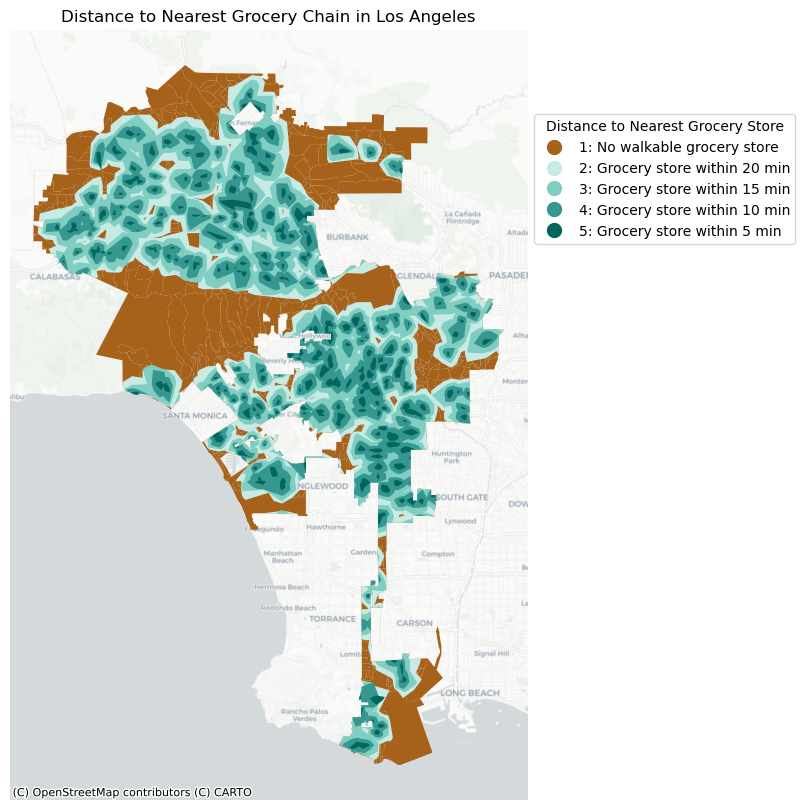

In [20]:
# Walksheds can expand into other municipalities, so we will clip the walkshed to the LA boundary.
walksheds_map=gpd.clip(walksheds, cityboundary_proj).sort_values(by=['time'],ascending=False)

# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: No walkable grocery store': '#a6611a',
              '2: Grocery store within 20 min': '#c7eae5',
              '3: Grocery store within 15 min': '#80cdc1',
              '4: Grocery store within 10 min': '#35978f',
              '5: Grocery store within 5 min': '#01665e'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
walksheds_map.loc[walksheds_map['time']==5, 'colors'] = '#01665e'
walksheds_map.loc[walksheds_map['time']==10, 'colors'] = '#35978f'
walksheds_map.loc[walksheds_map['time']==15, 'colors'] = '#80cdc1'
walksheds_map.loc[walksheds_map['time']==20, 'colors'] = '#c7eae5'
bg_geometries["colors"] = '#a6611a'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
#chain_with_neighborhood.plot(ax=ax, zorder=3,color='orange')
walksheds_map.plot(ax=ax, zorder=2, color=walksheds_map['colors'])
bg_geometries.plot(ax=ax, zorder=1, color=bg_geometries['colors'])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")

#Format plot axis, title, and basemap.
ax.axis('off')
ax.set_title('Distance to Nearest Grocery Chain in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

Now we'll determine which block groups "have access." We would prefer to proportionally allocate the population of each census block groups. However, for this project, we believe that the best way to approximate which block groups have access is by determining whether or not the centroid of the block group falls within the walkshed. Based on prior work, we believe that this is the best way to allocate entire block groups (rather than block group intersections) for a couple of reasons:
1) It more closely aligns with the spatial extent of the actual walksheds than using all block groups that intersect with the walkshed at all
2) Since we're talking about a vulnerable population in which many people have mobility limitations, we want to air on the side of underestimating access rather than overestimating access. 

First we will calculate each block group's centroid.

In [21]:
# Create a new dataframe to store information about grocery store access to a census block group's centroid.
bg_centroids=bg_geometries.copy()

# Create a centroid column with a geopandas calculation.
bg_centroids['centroid']=bg_centroids.centroid

# Make my new centroid column the primary geometry for the geodataframe. 
bg_centroids=bg_centroids.set_geometry('centroid')

Now we can join the walksheds to the census centroids.

In [22]:
#Join in the geodataframe of walksheds.
bg_access=bg_centroids.sjoin(walksheds, how="left")

#Remove duplicate BG caused by doing a left join but be sure to keep "best" walk access.
bg_access = bg_access.fillna(25).sort_values(by=['time'], ascending=True).drop_duplicates(subset='BG20', keep="first")

# Return block group boundary to being the primary geometry.
bg_access=bg_access.set_geometry('geometry')

Finally I use the columns that have been joined to categorize each census block groups based on how far away the nearest grocery chain is.

In [23]:
bg_access['grocery_walkable']= '1: No walkable grocery store'
bg_access.loc[bg_access['time']==20, 'grocery_walkable'] = '2: Grocery store within 20 min'
bg_access.loc[bg_access['time']==15, 'grocery_walkable'] = '3: Grocery store within 15 min'
bg_access.loc[bg_access['time']==10, 'grocery_walkable'] = '4: Grocery store within 10 min'
bg_access.loc[bg_access['time']==5, 'grocery_walkable'] = '5: Grocery store within 5 min'

Finally, I map my census tracts, categorized by their walk access to grocery stores.

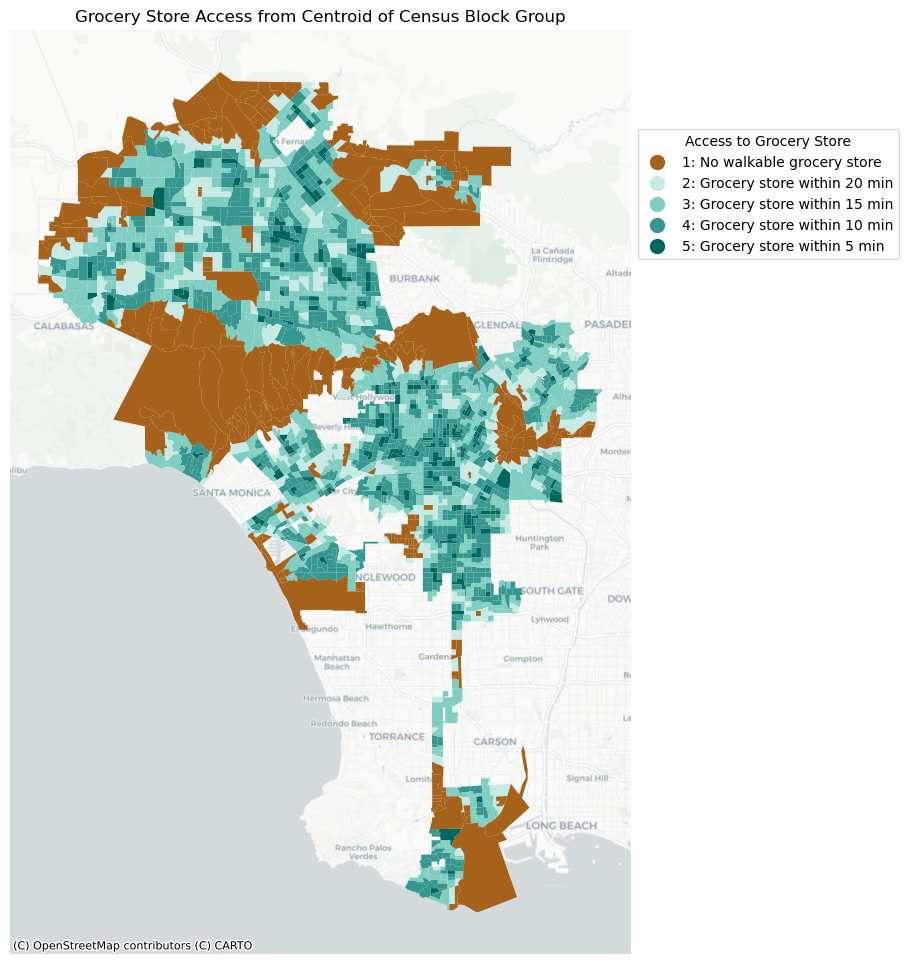

In [24]:
#Plot the block groups that allegedly have access and the grocery store locations.

# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: No walkable grocery store': '#a6611a',
              '2: Grocery store within 20 min': '#c7eae5',
              '3: Grocery store within 15 min': '#80cdc1',
              '4: Grocery store within 10 min': '#35978f',
              '5: Grocery store within 5 min': '#01665e'}

bg_access["colors"] = bg_access["grocery_walkable"].map(color_dict)


fig,ax = plt.subplots(figsize=(12,12))
ax = bg_access.plot(ax=ax, color = bg_access["colors"])

# Add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Access to Grocery Store")

#Format plot.
ax.axis('off')
ax.set_title('Grocery Store Access from Centroid of Census Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

Finally, we can use this information to do some basic calculations about how likely Seniors are to live within walking distance of a grocery chain, and whether they have worse (or better) acess than the general population of Los Angeles.

In [25]:
# Read file.
seniors=gpd.read_file('Percent_Senior_Basemap.geojson')

# Keep just necessary columns.
seniors=seniors[['BG20','Total Pop','Total Senior Pop']]
seniors.head()

BG20  Total Pop  Total Senior Pop
0  2742023        740                13
1  2739025        763               158
2  2739024        998               100
3  2739023       1098               240
4  2735023        923                69

To simplify high-level analysis at this stage, we will create a binary access categorization that considers a block group as having walk access to a grocery store if it's within 10 minutes.

In [26]:
access_simplififed=bg_access.copy()
access_simplififed.loc[access_simplififed['time']==20, 'grocery_walkable'] = '1: No walkable grocery store'
access_simplififed.loc[access_simplififed['time']==15, 'grocery_walkable'] = '1: No walkable grocery store'
access_simplififed.loc[access_simplififed['time']==10, 'grocery_walkable'] = '2: Grocery store within 10 min'
access_simplififed.loc[access_simplififed['time']==5, 'grocery_walkable'] = '2: Grocery store within 10 min'

In [27]:
# Merge info on number of seniors with grocery store access table.
senior_access=pd.merge(access_simplififed, seniors, how="left", on=["BG20"])

First, I want to create a new table that sums up all of the data across all block groups, so that I can conduct calculations about what percentage of Seniors and All Residents live within walking distance of a grocery store for the City of Los Angeles as a whole.

In [28]:
# Sum up all of the data for all of the block groups in each category.
senior_sums = senior_access.groupby(by='grocery_walkable').sum(numeric_only=True)

# Keep just the columns that we're interested in.
senior_sums=senior_sums[['Total Pop','Total Senior Pop']].reset_index(names='grocery_walkable')

# Create calculated columns. 
senior_sums['All Population']=round(senior_sums['Total Pop']/(senior_sums['Total Pop'].sum())*100)
senior_sums['Seniors']=round(senior_sums['Total Senior Pop']/(senior_sums['Total Senior Pop'].sum())*100)

# Create calculated columns. 
senior_sums['All Population']=round(senior_sums['Total Pop']/(senior_sums['Total Pop'].sum())*100)
senior_sums['Seniors']=round(senior_sums['Total Senior Pop']/(senior_sums['Total Senior Pop'].sum())*100)

# Drop columns that are no longer necessary now that calculation has been completed.
senior_sums=senior_sums.drop(columns=['Total Pop', 'Total Senior Pop'])

# Take a look at our table.
senior_sums

grocery_walkable  All Population  Seniors
0    1: No walkable grocery store            56.0     59.0
1  2: Grocery store within 10 min            44.0     41.0

To be able to easily plot this, we have to transpose this table.

In [29]:
# Transpose table.
senior_sums=senior_sums.transpose()

# Move column names from row 0 to columns.
senior_sums.columns = senior_sums.iloc[0]

# Now drop row 0 now that column names have been successfully extracted.
senior_sums = senior_sums.iloc[1:]

# Take a look at our table.
senior_sums

grocery_walkable 1: No walkable grocery store 2: Grocery store within 10 min
All Population                           56.0                           44.0
Seniors                                  59.0                           41.0

Now we can create our bar plot.

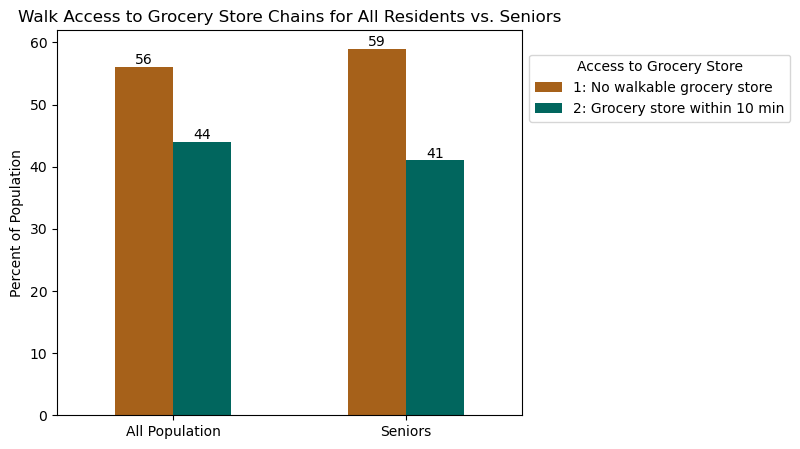

In [30]:
# Now I plot the pivot table.
fig, ax = plt.subplots(figsize=(6,5))

ax = senior_sums.plot(ax=ax, kind='bar',color=['#a6611a', '#01665e'] , legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis.
plt.xlabel(None)
plt.xticks(rotation=0)

# Ajust y-axis.
plt.ylabel("Percent of Population")

#Adjust table and legend.
plt.title("Walk Access to Grocery Store Chains for All Residents vs. Seniors")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Access to Grocery Store')

plt.show()

We can see from this chart that Seniors are more likely to live in a census block group that does not have a walkable grocery store (59% compared to 56%).

The final step is to understand which neighborhoods have particularly low access for seniors. We use a pivot table to calculate the percentage of seniors who are not within walking distance of a grocery store by neighborhood.

In [31]:
import numpy as np
# First I create a pivot table.
access_by_neighborhood = pd.pivot_table(senior_access, 
                          values="Total Senior Pop", 
                          index="neighborhood", 
                          columns="grocery_walkable", 
                          aggfunc=np.sum)
access_by_neighborhood=access_by_neighborhood.reset_index()

# Fill NA with 0.
access_by_neighborhood['1: No walkable grocery store']=access_by_neighborhood['1: No walkable grocery store'].fillna(0)
access_by_neighborhood['2: Grocery store within 10 min']=access_by_neighborhood['2: Grocery store within 10 min'].fillna(0)

# Now I calculate percentages
access_by_neighborhood['Total_Senior_Pop']=access_by_neighborhood['1: No walkable grocery store']+access_by_neighborhood['2: Grocery store within 10 min']
access_by_neighborhood['Pct_No_Grocery_Walkable']=round((access_by_neighborhood['1: No walkable grocery store']/
                                               (access_by_neighborhood['1: No walkable grocery store']+access_by_neighborhood['2: Grocery store within 10 min']))*100)

# Remove percentages for places with virtually no people.
access_by_neighborhood.loc[access_by_neighborhood['Total_Senior_Pop']< 50,  'Pct_No_Grocery_Walkable'] = None

# Add back in geometries.
access_by_neighborhood=pd.merge(access_by_neighborhood, neighborhoods[['neighborhood','geometry']], how="left", on=["neighborhood"]).set_geometry('geometry')

There are too many neighborhoods with nearly 100% of residents living outside of walking distance of a grocery store for a bar chart to be useful. Instead, we will use a map to understand the locations of the 25 neighborhoods with the lowest grocery store access for seniors.

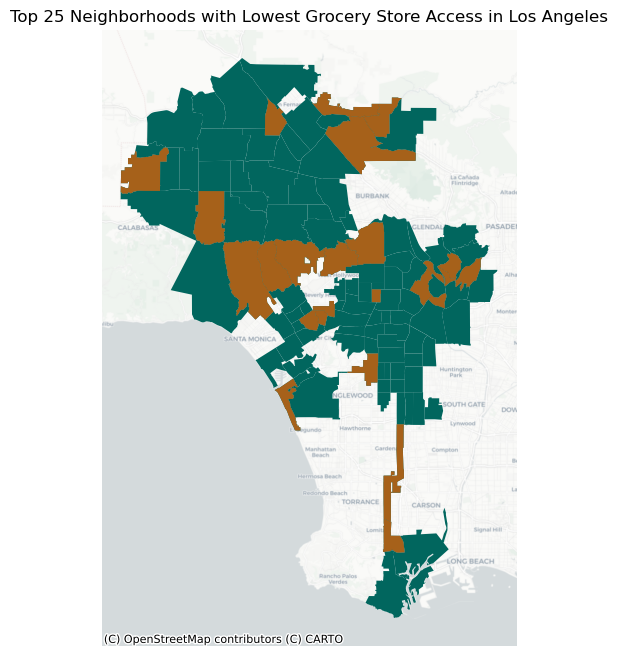

In [32]:
# Quick plot to see how things are going.
fig, ax= plt.subplots(figsize=(8,8))
access_by_neighborhood.sort_values('Pct_No_Grocery_Walkable',ascending=False).iloc[0:25].plot(ax=ax, zorder=2, color='#a6611a')
access_by_neighborhood.plot(ax=ax, zorder=1, color='#01665e')

#Format plot.
ax.axis('off')
ax.set_title('Top 25 Neighborhoods with Lowest Grocery Store Access in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

### Division of Labor:
<b>Carolyn:</b> Carolyn focused on analyses related to fixed route transit.<br>
<b>Lucy:</b> Lucy focused on analyses related to the senior population and Metro Micro zones.<br>
<b>Monisha:</b> Monisha focused on analyses related to household vehicle access and grocery store access.